This project aims to apply Transfer Learning technique for an image recognition problem of fish images from the 'A Large Scale Fish Dataset' Dataset.<br>
The idea of Transfer Learning is to use pre-trained models on different datasets, add some more layers and fine tune the model to the specific dataset in use.<br> In this case, we will use the popular MobileNetV2 CNN from the tensorflow library and fine tune by using the fish dataset.<br>

The model resulted in a 100% accuracy on training, validation and testing datasets, showing the power of transfer learning as well as the convenience of using pre trained models.

# Main Results Summary Dashboard:

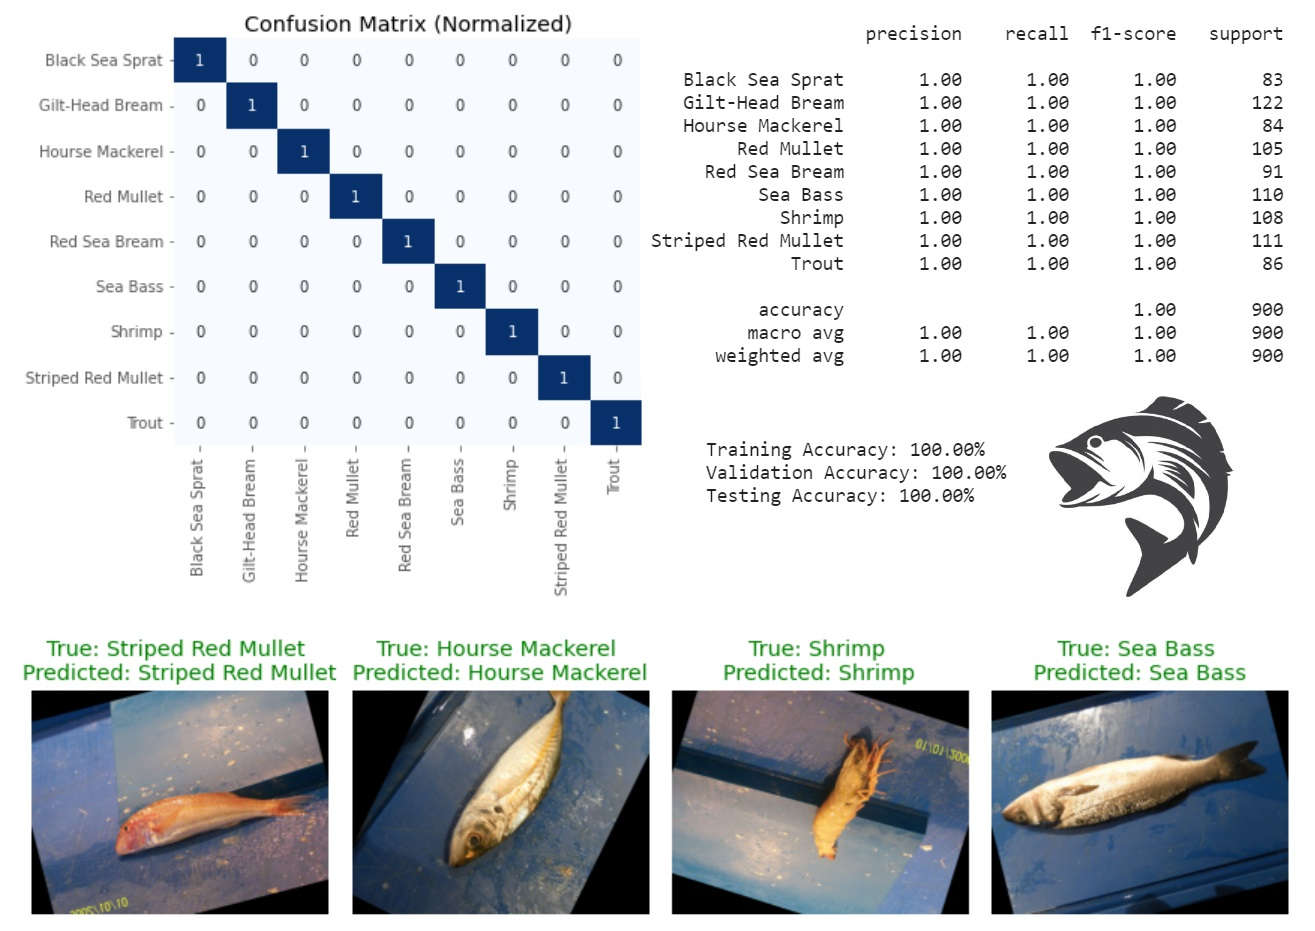

In [1]:
import os
import glob
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

from sklearn.metrics import confusion_matrix, classification_report

from sklearn.model_selection import train_test_split


plt.style.use('ggplot')

seed=42
tf.random.set_seed(seed)

# Files import

In [2]:
image_path = list(Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset').glob(r'**/*.png'))
image_labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], image_path))

In [3]:
image_path = pd.Series(image_path, name='path').astype(str)
image_labels = pd.Series(image_labels, name='label')

In [4]:
# create Dataframe with path and labels
df_image = pd.concat([image_path, image_labels], axis=1)

In [5]:
df_image.head()

,path,label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel


It looks like we should shuffle the dataset!

In [6]:
df_image = df_image.sample(frac=1).reset_index(drop = True)

In [7]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    18000 non-null  object
 1   label   18000 non-null  object
dtypes: object(2)
memory usage: 281.4+ KB


In [8]:
df_image.label.value_counts()

Shrimp                   1000
Sea Bass                 1000
Red Mullet               1000
Red Sea Bream            1000
Black Sea Sprat GT       1000
Hourse Mackerel GT       1000
Black Sea Sprat          1000
Shrimp GT                1000
Striped Red Mullet       1000
Striped Red Mullet GT    1000
Hourse Mackerel          1000
Trout                    1000
Red Mullet GT            1000
Red Sea Bream GT         1000
Gilt-Head Bream          1000
Trout GT                 1000
Sea Bass GT              1000
Gilt-Head Bream GT       1000
Name: label, dtype: int64

It looks like some pictures are labeled with 'GT'. By reading the Dataset documentation, we understand that GT stands for 'Ground Truth', but how do these pictures look like?

We will plot some pictures to check the pictures !

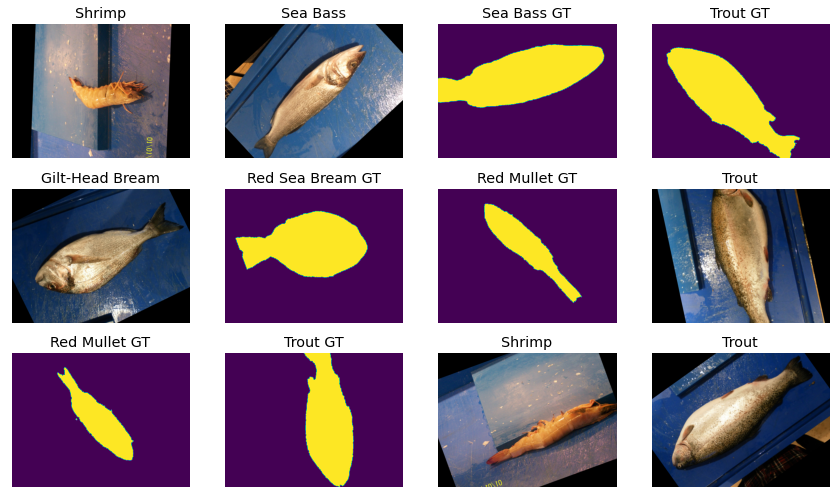

In [9]:
fig, axes = plt.subplots(3, 4, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_image.path[idx]))
    ax.set_title(df_image.label[idx])
plt.tight_layout()
plt.show()

We should definitely remove these GT pictures !

In [10]:
df_image = df_image[~df_image.label.str.contains("GT")]

In [11]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 0 to 17998
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 210.9+ KB


We removed 9000 pictures ! This means that each class had the GT version of pictures, which we removed.

# Data Preparation

Before feeding the images to the model, we need to define generators for the images!

First we shuffle the dataset

In [12]:
df_image = df_image.sample(frac=1).reset_index(drop = True)

Then we split the dataset into train and test sets

In [13]:
df_train, df_test = train_test_split(df_image, test_size=0.1, random_state=seed)

In [14]:
print('Training size: {} images\nTest size: {} images'.format(len(df_train), len(df_test)))

Training size: 8100 images
Test size: 900 images


# Generators definition

In [41]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    validation_split=0.2 # 20% of the training data will be used for validation
)

In [16]:
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

In [17]:
BATCH_SIZE = 64

In [18]:
train_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed,
    subset='training'
)

Found 6480 validated image filenames belonging to 9 classes.


In [19]:
val_images = train_generator.flow_from_dataframe(
    dataframe=df_train,
    x_col='path',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=seed,
    subset='validation'
)

Found 1620 validated image filenames belonging to 9 classes.


In [20]:
test_images = test_generator.flow_from_dataframe(
    dataframe=df_test,
    x_col='path',
    y_col='label',
    color_mode='rgb',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 900 validated image filenames belonging to 9 classes.


# Model definition: MobileNETV2 fine tuning

We define a 'create model' function with the base model (MobileNETV2) and two additional dense layers: one hidden layer with 64 neurons and the output layers with 9 layers, since there are 9 classes to be classified.

In [21]:
def create_model(input_shape=(224, 224, 3)):
    
    inputs = tf.keras.layers.Input(input_shape)
    
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), # the images are 224 x 224 with 3 channels (RGB)
        weights='imagenet',
        pooling='avg',
        include_top=False # we discard the last layer of the original net and replace it with 2 layers defined in the following
        )
    
    base_model.trainable = False # We won't re-train all the base model parameters, but just those of the layers we will add.
    
    x = base_model(inputs)
    x = tf.keras.layers.Dense(64, activation='relu')(x) # additional hidden layer
    outputs =  tf.keras.layers.Dense(9, activation='softmax')(x) #output layer for the 9 classes
    
    
    model = tf.keras.models.Model(inputs, outputs)
    
    return model

In [22]:
model = create_model(input_shape = (224, 224, 3))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

# Model Training

In [23]:
model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

In [24]:
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=5, # since we are running on CPU, we keep the number of epoch low
    callbacks=[
        tf.keras.callbacks.EarlyStopping( # we apply earlystopping to prevent overfitting
            monitor='val_loss',
            patience=1, # we choose patience=1 to stop the model fit if val_loss won't decrease for an epoch
            restore_best_weights=True # choose the best weights when early-stopping
        )
    ]
)

2021-10-19 17:57:52.658557: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5
102/102 [==============================] - 179s 2s/step - loss: 0.3120 - accuracy: 0.9167 - val_loss: 0.0381 - val_accuracy: 0.9951
Epoch 2/5
102/102 [==============================] - 175s 2s/step - loss: 0.0228 - accuracy: 0.9985 - val_loss: 0.0196 - val_accuracy: 0.9975
Epoch 3/5
102/102 [==============================] - 175s 2s/step - loss: 0.0114 - accuracy: 0.9995 - val_loss: 0.0125 - val_accuracy: 0.9994
Epoch 4/5
102/102 [==============================] - 176s 2s/step - loss: 0.0061 - accuracy: 1.0000 - val_loss: 0.0102 - val_accuracy: 0.9988
Epoch 5/5
102/102 [==============================] - 175s 2s/step - loss: 0.0039 - accuracy: 1.0000 - val_loss: 0.0074 - val_accuracy: 1.0000


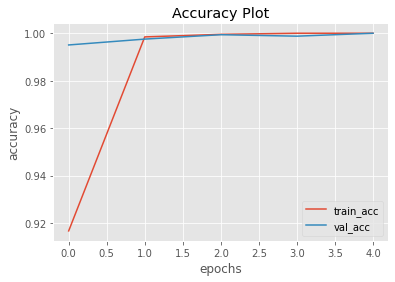

In [25]:
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title('Accuracy Plot')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

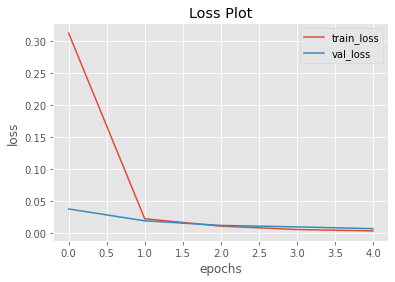

In [26]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title('Loss Plot')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

Loss and Accuracy look great ! Now we should check the performance on the test set !

# Model Testing

In [27]:
results = model.evaluate(test_images)

15/15 [==============================] - 19s 1s/step - loss: 0.0065 - accuracy: 1.0000


In [28]:
print('Training Accuracy: {:.2f}%'.format(history.history["accuracy"][-1:][0]*100))
print('Validation Accuracy: {:.2f}%'.format(history.history["val_accuracy"][-1:][0]*100))
print('Testing Accuracy: {:.2f}%'.format(results[1]*100))

Training Accuracy: 100.00%
Validation Accuracy: 100.00%
Testing Accuracy: 100.00%


In [29]:
print('Training Loss: {:.3f}'.format(history.history["loss"][-1:][0]))
print('Validation Loss: {:.3f}'.format(history.history["val_loss"][-1:][0]))
print('Testing Loss: {:.3f}'.format(results[0]))

Training Loss: 0.004
Validation Loss: 0.007
Testing Loss: 0.007


# Model Prediction : Fish Recognition

We call the method 'predict' of the neural network model:

In [30]:
pred = model.predict(test_images)

We check out the first predicted label!

In [31]:
pred[0]

array([1.6914956e-06, 1.1769470e-03, 4.2323711e-05, 9.9982688e-05,
       9.7066015e-01, 3.7863004e-04, 3.7480673e-05, 2.7379876e-02,
       2.2282501e-04], dtype=float32)

In [32]:
[i * 100 for i in pred[0]] # we multiply by 100 to transform these values into probabilities with percentage

[0.00016914956404434633,
 0.11769470293074846,
 0.004232371065882035,
 0.009998268797062337,
 97.0660150051117,
 0.037863003672100604,
 0.0037480673199752346,
 2.7379876002669334,
 0.02228250086773187]

The model predicts that the first image in the test set correponds to the fifth class with a probability of 97%<br>
In order to keep the most likely label for each predicted label, we will use 'np.argmax' function from numpy library.

In [33]:
pred = np.argmax(pred,axis=1)

Now we need to extract the labels and their indeces during testing

In [34]:
labels_1 = (train_images.class_indices)
labels_1

{'Black Sea Sprat': 0,
 'Gilt-Head Bream': 1,
 'Hourse Mackerel': 2,
 'Red Mullet': 3,
 'Red Sea Bream': 4,
 'Sea Bass': 5,
 'Shrimp': 6,
 'Striped Red Mullet': 7,
 'Trout': 8}

By calling the class_indices method on train_images, we can see that we get a dictionary where the keys are the classes and the values are the indexes.<br> We actually want to switch the keys with the values!

In [35]:
labels = {y:x for x, y in labels_1.items()}
labels

{0: 'Black Sea Sprat',
 1: 'Gilt-Head Bream',
 2: 'Hourse Mackerel',
 3: 'Red Mullet',
 4: 'Red Sea Bream',
 5: 'Sea Bass',
 6: 'Shrimp',
 7: 'Striped Red Mullet',
 8: 'Trout'}

Now we have the correct labels and indexes!

In [36]:
pred = [labels[idx] for idx in pred] # create a list of the predicted labels

In [37]:
y_test = list(df_test.label)
print(classification_report(y_test, pred))

                    precision    recall  f1-score   support

   Black Sea Sprat       1.00      1.00      1.00        83
   Gilt-Head Bream       1.00      1.00      1.00       122
   Hourse Mackerel       1.00      1.00      1.00        84
        Red Mullet       1.00      1.00      1.00       105
     Red Sea Bream       1.00      1.00      1.00        91
          Sea Bass       1.00      1.00      1.00       110
            Shrimp       1.00      1.00      1.00       108
Striped Red Mullet       1.00      1.00      1.00       111
             Trout       1.00      1.00      1.00        86

          accuracy                           1.00       900
         macro avg       1.00      1.00      1.00       900
      weighted avg       1.00      1.00      1.00       900



It looks like the net predicted all the images correctly

In [38]:
conf_matrix = confusion_matrix(y_test, pred, normalize='true')

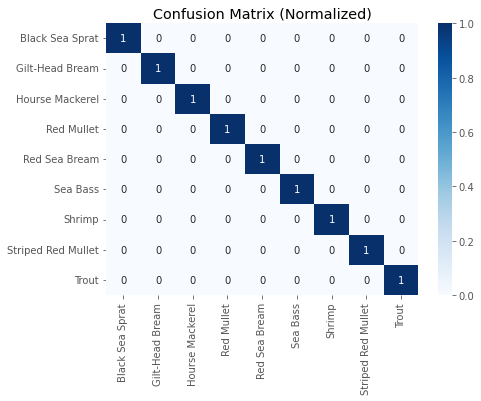

In [39]:
plt.figure(figsize = (7,5))
sns.heatmap(conf_matrix, cmap='Blues',annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)))
plt.title('Confusion Matrix (Normalized)')
plt.show()

Finally, we will display some test images with the actual and predicted labels

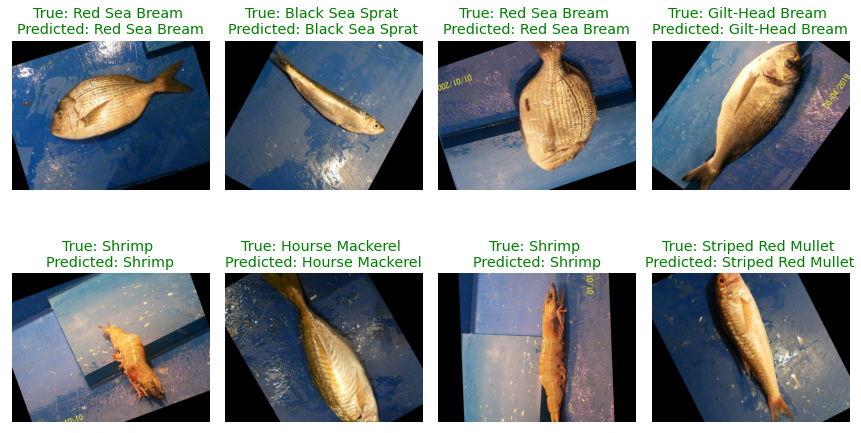

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12, 7), subplot_kw={'xticks': [], 'yticks': []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_test.path.iloc[idx]))
    ax.set_title("True: {} \nPredicted: {}".format(df_test.label.iloc[idx], pred[idx]), color=("green" if pred[idx]==df_test.label.iloc[idx] else "red"))
plt.tight_layout()
plt.show()

Indeed all of these 8 pictures have been correctly classified.

**Thank you for checking out my notebook! I hope everything is clearly explained 🤖!**

**If there are any questions or if you want me to check out your works let me know with a comment!**